<a href="https://colab.research.google.com/github/karthikvijayakumar/EVA/blob/kvk_development/Phase%202%20Session%2010/End_game.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [1]:
from PIL import Image, ImageOps, ImageDraw
from gym import error, spaces, utils, wrappers
from tqdm.notebook import trange
import gym
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle
import random
import seaborn as sns
import time
import torch
import torch.nn as nn
import torch.nn.functional as F

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Custom Gym Environment

In [0]:
class CityMap(gym.Env):
    metadata = {'render.modes': ['rgb_array']}
    reward_range = (-float('inf'), float('inf'))
    spec = None
    
    observation_window_size = 40
    # observation_window_size is the side length of the square surrounding the car
    # The car would see (observation_window_size/2) ahead and behind and (observation_window_size/2) to the left and right
    
    max_action = np.float64(1.0)

    max_turn_radians = np.pi/6.0
    # pi/6 radians = 180/6 = 30 degrees
    # The car can turn 30 degrees to the left or right    
    
    distance_threshold_done = 30
    # Distance to target to reach before considering the episode done
    
    goal_circle_radius = int(distance_threshold_done/2)

    #Max steps before we call the episode done
    max_episode_steps = 2500

    #State image size
    state_image_size = 20

    #Goal set
    goals = [ (726,546), (1154,158), (360,350) ] 
    
    def __init__(self, citymap, roadmask, car_image, render_pov = 'map'):
        self.action_space = spaces.Box(low = np.float64(-self.max_action), high = np.float64(self.max_action), shape = (1,) ) 
        # Action space is how many degrees to turn the car in radians
        
        self.observation_space = spaces.Box(low = 0, high = 255, shape = (self.observation_window_size, self.observation_window_size) ) 
        # All combinations of white and black pixels of observation_window_size x observation_window_size
        
        self.state = None
        
        self.citymap = citymap.copy()
        self.roadmask = ImageOps.invert( roadmask.copy() )
        self.car_image = car_image.copy()
        self.render_pov = render_pov
        
        #Find size of the roadmask for reference later
        self.roadmask_size_x, self.roadmask_size_y = self.roadmask.size

        # Find length of diagonal of the road mask image >= Max distance from goal
        self.road_mask_diagonal = np.sqrt( self.roadmask_size_x**2 + self.roadmask_size_y**2 )
        
        # Pad the road mask image to allow for rotations
        # Amount of padding required = ( diagonal length of the observation window )/2
        self.padding_size = int(self.observation_window_size/np.sqrt(2))
        padding = ( self.padding_size, self.padding_size, self.padding_size, self.padding_size )
        self.roadmaskpadded = ImageOps.expand( self.roadmask, padding, fill = 0 ) # Pad and fill with sand
        
        #Randomly permute the goal set for this episode
        rng = np.random.default_rng()
        self.episode_goal_order = rng.permutation(self.goals)
        
        #Choose the first element of the list as the starting goal
        self.curr_goal_index = 0

        #Set goal point
        self.goal_x, self.goal_y = self.episode_goal_order[self.curr_goal_index]
        # self.goal_x = 1154
        # self.goal_y = 158        
        
        self.car_pos_x = 0
        self.car_pos_y = 0

        #Set number of steps in this episode
        self.num_steps = 0

        # Variable to track split between various steps taken in this episode
        self.steps_split = {
            'road' : 0,
            'road_towards_goal' : 0,
            'road_away_goal' : 0,
            'sand' : 0,
            'sand_towards_goal' : 0,
            'sand_away_goal' : 0
        }
        
        self.reset()

    """
        Parameters:
        
        Returns:
            ( next_state, reward, done, info )
        
    """
    def step(self, action_array):

        # Type check to ensure we get a array of shape 1 where the element is a float32
        assert type(action_array) == np.ndarray, "Input action should be an nd array"
        assert action_array.shape == (1,), "Input action should be of shape (1,)"
        assert type(action_array[0]) == np.float32, "Input action arrays element must be a numpy float32"
        
        action = action_array[0]
        
        # Setting info to a empty dict
        info = {}

        # Things to compute
        # 1. Next position         
        # 2. Reward on moving to next position
        # 3. Update number of steps taken
        # 4. Update steps_split
        # 5. Has the current goal been reached? If yes shift to the next goal
        # 6. Is the episode done?
        # 7. Any info to pass on to the agent
        # 8. Combine Screen grab from next position and orientation to produce the next state

        # 1. Next position
        # From (pos_x, pos_y) we move forward with 'speed' steps in the direction 'angle+action*max_turn_radians'
        # The action given by the agent is from -1 to 1. The env maps the action to degrees of turn
        # New angle of car
        # Angle of the car lies in [-pi, pi)
        self.car_angle = self.car_angle + (action*self.max_turn_radians)
        if(self.car_angle < -np.pi):
            self.car_angle = self.car_angle + (2*np.pi) 
        elif(self.car_angle >= np.pi):
            self.car_angle = self.car_angle - (2*np.pi)
        
        # Car speed depends on whether we are riding on sand or not
        speed = 5 if self.roadmask.getpixel(( self.car_pos_x, self.car_pos_y )) == 255 else 2
        
        displacement_x = speed * np.sin( self.car_angle )
        displacement_y = -1 * speed * np.cos( self.car_angle )
        # Displacement y is negative since the top of the frame is y=0
        # Hence if the car is pointing upwards ( oriented at 0 degrees ) then the y values would decrease
        
        old_car_pos_x = self.car_pos_x
        old_car_pos_y = self.car_pos_y

        self.car_pos_x = self.car_pos_x + displacement_x
        self.car_pos_y = self.car_pos_y + displacement_y
        
        # Clip position to boundaries of the image
        self.car_pos_x = np.clip(self.car_pos_x, 0, self.roadmask_size_x-1)
        self.car_pos_y = np.clip(self.car_pos_y, 0, self.roadmask_size_y-1)
        
        # 2. Reward on moving to next position
        # Reward is computed based on a nested if-else condition
        # If on sand there are 2 cases:
        # a. On the boundary of the map and hitting into the wall -> Incentivize large turns to get out of the wall
        # b. Not on the boundary -> Incentivize movement towards the goal
        # If on road incentivize movement towards the goal        
        
        new_distance_from_goal = np.sqrt( (self.car_pos_x - self.goal_x)**2 + (self.car_pos_y - self.goal_y)**2 )
        
        pixel_value_at_car_pos = self.roadmask.getpixel((self.car_pos_x, self.car_pos_y))

        reward = 0

        if(pixel_value_at_car_pos == 0):
            #On sand

            if(
                ( (old_car_pos_x-self.car_pos_x) == 0 and (self.car_pos_x == 0 or self.car_pos_x >= self.roadmask_size_x-1) ) or 
                ( (old_car_pos_y-self.car_pos_y) == 0 and (self.car_pos_y == 0 or self.car_pos_y >= self.roadmask_size_y-1) )
            ):
                #Handle boundary cases
                reward = 0.5*np.abs(action)
                # Incentivize large turns when at the boundary
            elif(new_distance_from_goal < self.distance_from_goal):
                #Handle non boundary cases
                reward = 0.1
        else:
            #On road
            if(new_distance_from_goal < self.distance_from_goal):
                reward = 1
            else:
                reward = 0.3
        assert reward <= 1, "Reward for a single step pre-termination bonus is greater than 1. Reward : " +str(reward)
        
        # Component 4: Reward on termination conditions
        if( new_distance_from_goal < self.distance_threshold_done ):
            # Give high +ve reward when it has reached the goal
            reward += 50
        elif(
            old_car_pos_x-self.car_pos_x == 0 and old_car_pos_y-self.car_pos_y == 0 or
            ( (old_car_pos_x-self.car_pos_x) == 0 and (self.car_pos_x == 0 or self.car_pos_x >= self.roadmask_size_x-1) ) or 
            ( (old_car_pos_y-self.car_pos_y) == 0 and (self.car_pos_y == 0 or self.car_pos_y >= self.roadmask_size_y-1) ) 
            ):
            # Give high -ve reward when hitting a wall or moving into a corner
            reward -= 20

        # 3. Update number of steps taken
        self.num_steps += 1
 
        # 4. Update steps_split
        if(pixel_value_at_car_pos == 0):
            self.steps_split['sand'] +=  1
            if( new_distance_from_goal < self.distance_from_goal ):
                self.steps_split['sand_towards_goal'] += 1
            else:
                self.steps_split['sand_away_goal'] += 1
        else:
            self.steps_split['road'] += 1
            if( new_distance_from_goal < self.distance_from_goal ):
                self.steps_split['road_towards_goal'] += 1
            else:
                self.steps_split['road_away_goal'] += 1

        assert self.steps_split['sand']+self.steps_split['road'] == self.num_steps, "Steps splits doesnt match with num steps"

        info.update( self.steps_split )
        
        self.distance_from_goal = new_distance_from_goal

        # 5. Has the current goal been reached? If yes shift to the next goal
        if( new_distance_from_goal < self.distance_threshold_done and self.curr_goal_index < len(self.episode_goal_order) ):
            self.curr_goal_index += 1
            self.goal_x, self.goal_y = self.episode_goal_order[self.curr_goal_index % len(self.episode_goal_order)]

        # 6. Is the episode done? and compute info to pass to agent
        #   Two types of terination cases
        #       1. Happy case ( All goals reached )
        #       2. Not so happy case ( Max steps or car has hit a boundary and is not moving )

        if( (new_distance_from_goal < self.distance_threshold_done and self.curr_goal_index == len(self.episode_goal_order)) or
            self.num_steps == self.max_episode_steps or
            ( old_car_pos_x-self.car_pos_x == 0 and old_car_pos_y - self.car_pos_y == 0)
            ):
            # Either we have exceed the max steps for this episode or the car is not moving
            done = True
            if( new_distance_from_goal < self.distance_threshold_done and self.curr_goal_index == len(self.episode_goal_order) ):
                info['termination_reason'] = 'reached all goals'
            elif( self.num_steps == self.max_episode_steps ):                
                info['termination_reason'] = 'max steps'
            elif( old_car_pos_x-self.car_pos_x == 0 and old_car_pos_y - self.car_pos_y == 0 ):
                info['termination_reason'] = 'car not moving'
            # Return a zero screen grab, zero orientation and zero distance in case of termination
        else:
            done = False
            info['termination_reason'] = 'not terminated'

        # 7. Any info to pass on to the agent
        info['curr_goal_index'] = self.curr_goal_index

        # 8. Combine screen grab from current position with orientation and distance to goal to form next state
        # For done states we return a zero screen grab, orientation and distance to goal
        if(done):
            next_state = (self._zero_screen_grab(),0,0)
        else:
            next_state = ( 
                self._extract_current_frame(), 
                self._compute_orientation_towards_goal()/np.pi , 
                self._compute_distance_from_goal()/self.road_mask_diagonal
                )
        # We scale the orientation and distance by their max values to ensure their absolute values dont cross one

        assert new_distance_from_goal<self.distance_threshold_done or reward <= 1, "Reward for a non-terminating step is greater than 1. Reward : " +str(reward)
        return next_state, reward, done, info

    """
        Zero screen grab for episode termination conditions
    """
    def _zero_screen_grab(self):
        screen_grab = np.expand_dims( 
                np.expand_dims( 
                    np.zeros( self.state_image_size **2 ).reshape(( self.state_image_size , self.state_image_size )),
                    axis = 0 
                ),
                axis = 0 )
        return screen_grab

    """
        Definition of orientation:
            With respect to the axes of car ( car's forward pointing upwards ), at how many degrees is the goal
            orientation lies in the range [-pi,pi)

        We compute this in two steps:
        Step 1: At what angle is the goal with respect to the vertical
            Angle of goal wrt horizontal is tan_inverse( distance in y axis / distance in x axis )
            Angle of goal wrt vertical is 90 + the above = 90 + tan_inverse( distance in y axis / distance in x axis )        
        Step 2: Subtract the angle of the car from the above quantity to get angle relative to the car axes
            Angle of goal wrt car = 90 + tan_inverse( distance in y axis / distance in x axis ) - car angle wrt vertical
    """
    def _compute_orientation_towards_goal(self):
        orientation = np.arctan2( self.goal_x - self.car_pos_x, self.car_pos_y - self.goal_y ) - self.car_angle

        if(orientation >= np.pi):
            orientation = orientation - (2*np.pi)
        elif(orientation < -np.pi):
            orientation = orientation + (2*np.pi)
        
        return orientation
    
    """
        Simple euclidean distance computation
        Abstracted to a function to avoid rewriting in multiple places
    """
    def _compute_distance_from_goal(self):
        return np.sqrt( (self.car_pos_x - self.goal_x)**2 + (self.car_pos_y - self.goal_y)**2 ) 

    """
        Extracts the frame that the agent/car currently sees
        With respect to the frame extracted the car is always pointing upward
        Keeping the orientation fixed is key since else for the same scene( screen grab ), the car can be in different orientations 
        and hence should take different actions
           
        Parameters:
            None
        
        Returns:
            img - Numpy array of shape ( observation_window_size/2, observation_window_size/2 )
    """
    def _extract_current_frame(self):
        # We know the current position of the car
        # Step 1: Extract a square of size observation_window_size*sqrt(2) surrounding the car ( Call this rough cut )
        # Step 2: Rotate the rough cut image around the center by angle of the car
        # Step 3: Extract a square of size observation_window_size around the center
        # Step 4: Extract a square of what is in front of the car
        # Step 5: Sacling down the image to the required size
        
        # Step 1: Extract a square of size observation_window_size*sqrt(2) surrounding the car ( Call this rough cut )
        # We need to use the padded version of the road mask here
        # Hence we add self.padding_size to the x,y position of the car
        bounding_box_rough_cut = ( self.car_pos_x, self.car_pos_y, self.car_pos_x+(2*self.padding_size), self.car_pos_y+(2*self.padding_size) )

        rough_cut = self.roadmaskpadded.crop(bounding_box_rough_cut)
        
        # Step 2: Rotate the rough cut image around the center by angle of the car
        
        rough_cut_rotated = rough_cut.rotate( self.car_angle * (180/np.pi) )
        # PIL's rotate function:
        #  - takes input in degrees ( 180 degrees = pi radians; x radians = x*(180/pi) degrees )
        #  - by default rotates around the center of the image
        #  - rotates anti-clockwise
        
        # Step 3: Extract a square of size observation_window_size around the center
        # Center of the rough cut image is ( rough_cut_size/2, rough_cut_size/2 )
        
        bounding_box_current_frame = ( 
            self.padding_size - (self.observation_window_size/2), 
            self.padding_size - (self.observation_window_size/2), 
            self.padding_size + (self.observation_window_size/2), 
            self.padding_size + (self.observation_window_size/2)
        )
        
        current_frame = rough_cut_rotated.crop(bounding_box_current_frame)

        # Step 4: Cropping out to only what is visible in front of the car
        bounding_box_forward_view = (
            int(self.observation_window_size/4),
            0,
            int((3*self.observation_window_size)/4),
            int(self.observation_window_size/2)
        )

        forward_view = current_frame.crop(bounding_box_forward_view)
        
        # Scaling down the image to half the dimensions for optimising memory and simplifying input to agent
        forward_view = forward_view.resize((self.state_image_size,self.state_image_size), resample = Image.NEAREST )
        # In the current setting self.image_size is set to 20 and forward_view was already a 20x20 image
        # Hence this operation does not do anything.
        # If one increase the observation window size then this resizing would be useful

        return np.expand_dims( np.expand_dims( np.asarray(forward_view)/255, axis = 0 ), axis = 0 )
    
    def reset(self):
        #Randomly initialise the starting position and set velocity
        self.car_pos_x = np.random.randint( 0, self.roadmask_size_x )
        self.car_pos_y = np.random.randint( 0, self.roadmask_size_y )
        # self.car_pos_x = 100
        # self.car_pos_y = 445
        # Car position is measured with respect to the road mask ( without padding ). (0,0) is top left
        self.car_angle = np.random.uniform(-1,1) * np.pi
        # self.car_angle = 0
        # Initial angle ranges from 0 to 2*pi
        # Angle measures rotation from vertical axis (i.e angle = 0 when car is heading upwards in the map)
        
        #Distance from goal
        self.distance_from_goal = self._compute_distance_from_goal()

        #Set num_steps to 0
        self.num_steps = 0        

        #Set steps splits to zero
        self.steps_split = {
            'road' : 0,
            'road_towards_goal' : 0,
            'road_away_goal' : 0,
            'sand' : 0,
            'sand_towards_goal' : 0,
            'sand_away_goal' : 0
        }

        # Rerandomise the goal order
        rng = np.random.default_rng()
        self.episode_goal_order = rng.permutation(self.goals)
        
        # Reset cur goal index
        self.curr_goal_index = 0

        #Set goal point
        self.goal_x, self.goal_y = self.episode_goal_order[self.curr_goal_index]        
                
        return (self._extract_current_frame(), self._compute_orientation_towards_goal()/np.pi, self.distance_from_goal/self.road_mask_diagonal )
        # We scale the orientation and distance by their max values to ensure their absolute values dont cross one


    def render(self, mode='rgb_array', close=False):        
        #Build image of map with goal and car overlaid
        
        #Create a copy of the map
        map_copy = self.citymap.copy()
        
        #Draw a circle over the goal
        draw = ImageDraw.Draw(map_copy)
        draw.ellipse( 
            (self.goal_x - self.goal_circle_radius, 
             self.goal_y-self.goal_circle_radius, 
             self.goal_x+self.goal_circle_radius, 
             self.goal_y+self.goal_circle_radius
            ), 
            fill = 'red', 
            outline = 'red', 
            width = 1 
        )
        del(draw)
        
        # Create a copy of the car and rotate it to the currrent orientation according to the env state
        car_image_copy = self.car_image.copy().rotate( 360 - (self.car_angle*180/np.pi), expand = True )
        car_size_x, car_size_y = car_image_copy.getbbox()[2:4] # The last 2 coordinates represent the size of the car
        
        #Overlay the car on the map ( copy )
        map_copy.paste( car_image_copy, box = ( int(self.car_pos_x - (car_size_x/2)), int(self.car_pos_y - (car_size_y/2)) ) )
        del(car_image_copy)
        del(car_size_x)
        del(car_size_y)        
                
        if mode == 'rgb_array':
            if(self.render_pov == 'map'):            
                return np.asarray(map_copy)[:,:,[2,1,0,3]]
                # PIL represents images in RGB
                # Open AI gym seems to use BGR. Hence swapping the R and B channels                
                # The 4th channel is the alpha channel
            elif(self.render_pov == 'car'):
                current_frame = Image.fromarray( self._extract_current_frame().squeeze(0).squeeze(0)*255 ).convert('RGB')
                current_frame = current_frame.resize((self.observation_window_size, self.observation_window_size))
                return np.asarray(current_frame)
    
    def close(self):
        pass

# Model helpers

In [0]:
class ReplayBuffer(object):

  def __init__(self, max_size=1e6):
    self.storage = []
    self.max_size = max_size
    self.ptr = 0

  def add(self, transition):
    if len(self.storage) == self.max_size:
      self.storage[int(self.ptr)] = transition
      self.ptr = (self.ptr + 1) % self.max_size
    else:
      self.storage.append(transition)

  def sample(self, batch_size):
    sample_tuples = random.sample(self.storage, batch_size)
    batch_states, batch_next_states, batch_actions, batch_rewards, batch_dones = tuple(zip(*sample_tuples))

    return batch_states, batch_next_states, batch_actions, batch_rewards, batch_dones

def evaluate_policy(policy, env, eval_episodes = 3):  
  episode_rewards = []
  episode_lengths = []  
  actions = []
  for episode_num in range(eval_episodes):
    obs = env.reset()
    done = False
    curr_episode_reward = 0
    curr_episode_length = 0
    while not done:
      action = policy.select_action(obs)
      actions.append(action)
      obs, reward, done, info = env.step(action)
      curr_episode_reward += reward
      curr_episode_length += 1
    
    episode_rewards.append(curr_episode_reward)
    episode_lengths.append(curr_episode_length)
  avg_reward = np.mean(episode_rewards)
  print ("---------------------------------------")
  print ("Episode lengths: ", episode_lengths )
  print ("Rewards per episode: ", episode_rewards )
  print ("Average Reward over the Evaluation Step: %f" % (avg_reward))
  print ("Average action: %f" % (np.mean(actions)) )
  print ("Std deviation action: %f" % (np.std(actions)) )
  print ("---------------------------------------")
  return avg_reward

# Generic helpers

In [0]:
#Helper function
def mkdir(base, name):
    path = os.path.join(base, name)
    if not os.path.exists(path):
        os.makedirs(path)
    return path

# Models

Some notes on the implementation below

- The TD3 implementation below heavily derives from [OpenAI's spinning up](https://github.com/openai/spinningup/tree/master/spinup/algos/pytorch/td3).
- As of now I have decided to entirely do away with all convolutional layers
- In Atari or other envs the image passed to the agent is not binary in nature and requires feature extraction and simplification to a point it can be used for classification etc.
- In our case the roadmask is already binary in nature and doesnt really require further processing
- A simple average pooling of the screen grab returned by the agent tells us in 
which sections the road is and where it is not. This information is enough for the agent to learn.
- Potentially with some convolutions it can learn to identify horizontal and vertical lines. Given the agent learns without them I dont see the need as of now

In [0]:
class Actor(nn.Module):
    def __init__(self, action_dim, max_action):
        super(Actor, self).__init__()        
        self.avg_pool = nn.AvgPool2d(kernel_size = 4, stride=4)
        self.linear_1 = nn.Linear(25+2,400)
        self.linear_2 = nn.Linear(400,300)        
        self.head = nn.Linear(300, action_dim)
        # 25 values from the avg pooling of a 20x20 matrix with a 4x4 kernel 
        self.max_action = max_action

    def forward(self, state):
        screen, orientation, dist_goal = state
        x = self.avg_pool( screen )
        x = x.view(x.size(0), -1)

        #Concatenate orientation and distance to goal with the output of the convolutional layers
        x = torch.cat([x, orientation, dist_goal], 1)

        # Run it through FC layer        
        x = F.relu(self.linear_1(x))                
        x = F.relu(self.linear_2(x))
        x = self.head(x)        
        x = torch.tanh(x)        

        return self.max_action * x

class Critic(nn.Module):

    def __init__(self):
        super(Critic, self).__init__()
        # Defining the first Critic neural network
        self.critic1_avg_pool = nn.AvgPool2d(kernel_size = 4, stride=4)

        self.critic1_linear_1 = nn.Linear(25+2+1, 400)
        self.critic1_linear_2 = nn.Linear(400, 300)         
        self.critic1_head = nn.Linear(300, 1)
        # 25 values from the avg pooling of a 20x20 matrix with a 4x4 kernel 
        # 2 additional inputs - orientation and distance from goal, 
        # 1 input - action
        # Critic gives out only 1 value hence the output dimension is one

        # Defining the second Critic neural network
        self.critic2_avg_pool = nn.AvgPool2d(kernel_size = 4, stride=4)
        self.critic2_linear_1 = nn.Linear(25+2+1, 400)
        self.critic2_linear_2 = nn.Linear(400, 300) 
        self.critic2_head = nn.Linear(300, 1)
        # 25 values from the avg pooling of a 20x20 matrix with a 4x4 kernel 
        # 2 additional inputs - orientation and distance from goal, 
        # 1 input - action
        # Critic gives out only 1 value hence the output dimension is one

    def forward(self, state, action):
        screen, orientation, dist_goal = state
        ###############
        ## Critic 1
        ###############
        # Pass through convolutional layers
        x1 = self.critic1_avg_pool( screen ) 
        x1 = x1.view(x1.size(0), -1)

        #Concatenate action with the output of the convolutional layers
        x1 = torch.cat([x1, orientation, dist_goal, action], 1)

        #Pass through FC layer
        x1 = F.relu( self.critic1_linear_1(x1) )
        x1 = F.relu( self.critic1_linear_2(x1) ) 
        x1 = self.critic1_head(x1)

        ###############
        # Critic 2
        ###############

        #Pass through convolutional layers
        x2 = self.critic2_avg_pool( screen ) 
        x2 = x2.view(x2.size(0), -1)

        #Concatenate action with the output of the convolutional layers
        x2 = torch.cat([x2, orientation, dist_goal, action], 1)

        #Pass through FC layer
        x2 = F.relu( self.critic2_linear_1(x2) )
        x2 = F.relu( self.critic2_linear_2(x2) )
        x2 = self.critic2_head(x2)

        return x1, x2

    def Q1(self, state, action):   
        screen, orientation, dist_goal = state
        ###############
        ## Critic 1
        ###############
        # Pass through convolutional layers
        x1 = self.critic1_avg_pool( screen )
        x1 = x1.view(x1.size(0), -1)

        #Concatenate action with the output of the convolutional layers
        x1 = torch.cat([x1, orientation, dist_goal, action], 1)

        #Pass through FC layer
        x1 = F.relu( self.critic1_linear_1(x1) )
        x1 = F.relu( self.critic1_linear_2(x1) )
        x1 = self.critic1_head(x1)

        return x1
    
class TD3(object):

    def __init__(self, action_dim, max_action, batch_size, discount, polyak, policy_noise, noise_clip, policy_freq, actor_lr, critic_lr, device):
        self.device = device
        self.actor = Actor(action_dim, max_action).float().to(self.device)
        self.actor_target = Actor(action_dim, max_action).float().to(self.device)
        self.actor_target.load_state_dict(self.actor.state_dict())
        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(), lr = actor_lr)
        self.actor_lr_scheduler = torch.optim.lr_scheduler.StepLR(self.actor_optimizer, step_size = 2500, gamma = 0.5)
        self.critic = Critic().float().to(self.device)
        self.critic_target = Critic().float().to(self.device)
        self.critic_target.load_state_dict(self.critic.state_dict())
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(), lr = critic_lr)
        self.critic_lr_scheduler = torch.optim.lr_scheduler.StepLR(self.critic_optimizer, step_size = 5000, gamma = 0.5)
        self.batch_size = batch_size
        self.discount = discount
        self.polyak = polyak
        self.policy_noise = policy_noise
        self.noise_clip = noise_clip
        self.policy_freq = policy_freq
        self.max_action = max_action
        self.action_dim = action_dim

        #Turn off gradients for target models to ensure they only update via polyak averaging
        for param in self.critic_target.parameters():
            param.requires_grad = False
        for param in self.actor_target.parameters():
            param.requires_grad = False

    """
    Input params:
    state - Tuple with 3 components ( screen, action, orientation )
    """
    def select_action(self, state):
        screen, orientation, dist_goal = state
        # orientation and dist_goals are scalars
        screen = torch.FloatTensor(screen).to(self.device)
        orientation = torch.FloatTensor([orientation]).view(-1,1).to(self.device) 
        dist_goal = torch.FloatTensor([dist_goal]).view(-1,1).to(self.device)
        with torch.no_grad():
            # torch.nograd should technically not be required since its a brand new constructed tensor
            # However playing safe here
            result = self.actor( (screen,orientation,dist_goal) ).cpu().detach().numpy().squeeze(0)
            # result = self.actor( (screen,orientation,dist_goal) ).cpu().data.numpy().flatten()[0]
        return result

    def compute_critic_loss(self, state, next_state, action, reward, done):
        #Current Q values( critic )
        current_q1, current_q2 = self.critic(state, action)    

        # Computing target Q values from bellman equation
        with torch.no_grad():
            target_next_action = self.actor_target(next_state)

        #Add noise to next action from target actor
        noise_distribution = torch.distributions.normal.Normal(0, self.policy_noise)
        noise = noise_distribution.sample(torch.Size([self.batch_size])).clamp(-self.noise_clip,self.noise_clip).view(-1,1).to(self.device)
        target_next_action = (target_next_action + noise).clamp(-self.max_action, self.max_action)

        #Min Q values from target critic
        target_q1, target_q2 = self.critic_target(next_state, target_next_action)
        min_target_q = torch.min(target_q1, target_q2)

        #Target Q value
        target_q = reward + (1-done)*self.discount*min_target_q

        #Loss
        loss_critic = F.smooth_l1_loss(current_q1, target_q) + F.smooth_l1_loss(current_q2, target_q)
        loss_info = dict( 
            q1_vals = current_q1.cpu().detach().numpy(),
            q2_vals = current_q2.cpu().detach().numpy(), 
        )

        return loss_critic, loss_info

    # Actor loss for a state is the critic value for that state
    def compute_actor_loss(self, state):
        return -self.critic.Q1(state, self.actor(state)).mean()

    def update_critic(self, data, iteration):

        state, next_state, action, reward, done = data

        screen, orientation, dist_goal = state
        next_screen, next_orientation, next_dist_goal = state    

        # Compute critic loss and update critic
        self.critic_optimizer.zero_grad()
        critic_loss, critic_loss_info = self.compute_critic_loss(state, next_state, action, reward, done)
        critic_loss.backward()
        self.critic_optimizer.step()
        self.critic_lr_scheduler.step()

    def update_actor(self, state ):
        #Freeze critics
        for param in self.critic.parameters():
            param.requires_grad = False

        self.actor_optimizer.zero_grad()
        actor_loss = self.compute_actor_loss(state)
        # print(actor_loss)
        actor_loss.backward()
        self.actor_optimizer.step()
        self.actor_lr_scheduler.step()

        #Unfreeze critics
        for param in self.critic.parameters():
            param.requires_grad = True

    def update_target_networks(self):

        with torch.no_grad():
            #Update critic
            for param, target_param in zip(self.critic.parameters(), self.critic_target.parameters() ):
                target_param.data.mul_(self.polyak)
                target_param.data.add_( (1-self.polyak)*param.data )

            #Update actor
            for param, target_param in zip(self.actor.parameters(), self.actor_target.parameters() ):
                target_param.data.mul_(self.polyak)
                target_param.data.add_( (1-self.polyak)*param.data )


    def update_policy(self, replay_buffer, iterations):

        # Save state of actor and critic at the start of the training cycle        
        critic_frozen = Critic().float().to(self.device)
        critic_frozen.load_state_dict(self.critic.state_dict())

        actor_frozen = Actor(self.action_dim, self.max_action).float().to(self.device)       
        actor_frozen.load_state_dict( self.actor.state_dict() )

        for it in trange(iterations, desc = "T3D train function loop" ):

            state, next_state, action, reward, done = replay_buffer.sample(self.batch_size)

            screen, orientation, dist_goal = tuple(zip(*state))
            next_screen, next_orientation, next_dist_goal = tuple(zip(*next_state))

            #Converting inputs from replay buffer into pytorch tensors
            screen = torch.FloatTensor(screen).squeeze(1).to(self.device)
            orientation = torch.FloatTensor(orientation).view(-1,1).to(self.device)
            dist_goal = torch.FloatTensor(dist_goal).view(-1,1).to(self.device)

            next_screen = torch.FloatTensor(next_screen).squeeze(1).to(self.device)
            next_orientation = torch.FloatTensor(next_orientation).view(-1,1).to(self.device)
            next_dist_goal = torch.FloatTensor(next_dist_goal).view(-1,1).to(self.device)

            reward = torch.FloatTensor(reward).view(-1,1).to(self.device)
            action = torch.FloatTensor(action).view(-1,1).to(self.device)
            done = torch.FloatTensor(done).view(-1,1).to(self.device)

            state = (screen, orientation, dist_goal)
            next_state = (next_screen, next_orientation, next_dist_goal)

            #Compute critic loss and update critic
            self.update_critic((state, next_state, action, reward, done), it)

            if( it % self.policy_freq == 0):
                self.update_actor(state)
                self.update_target_networks()
        
        # Check how much the model has changed at the end of the training cycle
        critic_relevant_params = list( filter( lambda x: ('weight' in x) or ('bias' in x) , self.critic.state_dict().keys() ) )
        actor_relevant_params = list( filter( lambda x: ('weight' in x) or ('bias' in x) , self.actor.state_dict().keys() ) )

        critic_change = []
        actor_change = []
        
        for param in critic_relevant_params:
            critic_change.append( np.abs(self.critic.state_dict()[param].cpu().detach() - critic_frozen.state_dict()[param].cpu().detach()))

        for param in actor_relevant_params:
            actor_change.append( np.abs( self.actor.state_dict()[param].cpu().detach() - actor_frozen.state_dict()[param].cpu().detach() ) )

        # critic_change and actor_change are now a list of tensors
        # There will be one element in the list for each layer in the networks

        print("Sum absolute change critic: ", np.sum( [ torch.sum( torch.flatten( torch.abs(x) ) ) for x in critic_change ] ) )
        print("Sum absolute change actor: ", np.sum( [ torch.sum( torch.flatten( torch.abs(x) ) ) for x in actor_change ] ) )
        del(critic_change)
        del(actor_change)
        del(actor_frozen)
        del(critic_frozen)

    # Making a save method to save a trained model
    def save(self, filename, directory):
        torch.save(self.actor.state_dict(), '%s/%s_actor.pth' % (directory, filename))
        torch.save(self.critic.state_dict(), '%s/%s_critic.pth' % (directory, filename))

    # Making a load method to load a pre-trained model
    def load(self, filename, directory):
        self.actor.load_state_dict(torch.load('%s/%s_actor.pth' % (directory, filename)))
        self.critic.load_state_dict(torch.load('%s/%s_critic.pth' % (directory, filename)))

# Env setup

In [6]:
# Setup gym environment
citymap = Image.open("citymap.png")
roadmask = Image.open("MASK1.png").convert('1').convert('L')
# Converting to binary and back to grayscale to ensure there are only full black and white pixels
car_image = Image.open("car_upright.png")
car_image_width, car_image_height = car_image.getbbox()[2:4]
car_image_resized = car_image.resize( (int(car_image_width/4), int(car_image_height/4)) )

env = CityMap(citymap, roadmask, car_image_resized)

/usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


# Policy setup

In [7]:
###########
# Setup model attributes
############

# Selecting the device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#Setting params
seed = 42
env_name = "CityMap"
max_action = env.max_action
action_dim = env.action_space.shape[0]
seed = 0 # Random seed number
start_timesteps = 1e4 # Number of iterations/timesteps before which the model randomly chooses an action, and after which it starts to use the policy network
eval_freq = 5e3 # How often the evaluation step is performed (after how many timesteps)
max_timesteps = 5e4 # Total number of iterations/timesteps
save_models = True # Boolean checker whether or not to save the pre-trained model
expl_noise = 0.02 # Exploration noise - STD value of exploration Gaussian noise
batch_size = 256 # Size of the batch
discount = 0.90 # Discount factor gamma, used in the calculation of the total discounted reward
polyak = 0.5 # Target network update rate
policy_noise = 0.02 # STD of Gaussian noise added to the actions for the exploration purposes during model training
noise_clip = 0.5 # Maximum value of the Gaussian noise added to the actions (policy)
policy_freq = 2 # Number of iterations to wait before the policy network (Actor model) is updated
actor_lr = 0.0001
critic_lr = 0.0001
train_iterations = 100 # Number of iterations to run the training cycle for each time an episide is over
# Params for epsilon greedy random action
eps_start = 1.0
eps_end = 0.05
eps_decay = 5000

#Creating policy object
policy = TD3(
    action_dim, 
    max_action, 
    batch_size = batch_size, 
    discount = discount, 
    polyak = polyak, 
    policy_noise = policy_noise, 
    noise_clip = noise_clip, 
    policy_freq = policy_freq, 
    actor_lr = actor_lr,
    critic_lr = critic_lr,
    device = device )

#File name for saving actor and critic models
file_name = "%s_%s_%s" % ("TD3", env_name, str(seed))
print ("---------------------------------------")
print ("Settings: %s" % (file_name))
print ("---------------------------------------")


#Create directories for storing models and evaluations
mkdir('.', 'pytorch_models')
mkdir('.', 'results')

#Set random seeds
env.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)

#Create the experience replay buffer
replay_buffer = ReplayBuffer(max_size=int(max_timesteps/2))

---------------------------------------
Settings: TD3_CityMap_0
---------------------------------------


# Policy training

In [8]:
env.reset() #Reset env before evaluating
#List for storing model evaluations
evaluations = [evaluate_policy(policy, env)]
evaluation_timesteps = [0]
#Reset env after evaluation
env.reset()

# Interaction with environment and subsequent training
episode_num = 0
episode_timesteps = 0
episode_reward = 0
done = True
info = {}
timesteps_since_eval = 0


for timestep in trange(int(max_timesteps)):

    assert episode_timesteps == env.num_steps, "Env.num_steps and episode_timesteps are out of sync; env.num_steps" + str(env.num_steps) + "; episode_timesteps : " + str(episode_timesteps)
    assert episode_timesteps <= env.max_episode_steps, "Episode exceeding max length " + str(env.max_episode_steps) + "; Episode timesteps = " + str(episode_timesteps) 

    if(done):        
        # Update the policy after an episode has completed
        if(timestep>0):
            print(
                "Total Timesteps: {} Episode Num: {} Episode length: {} Reward: {} Info: {}".format(
                timestep, episode_num, env.num_steps, np.round(episode_reward,2), info)
            )
            if(len(replay_buffer.storage) > batch_size):
                policy.update_policy(replay_buffer, episode_timesteps)
            else:
                print("Replay buffer length too small : " + str(len(replay_buffer.storage)) )

        #Save model
        policy.save(file_name, directory="./pytorch_models")

        #Evaluate policy if its time
        if(timesteps_since_eval >= eval_freq):
            print("Evaluating policy")
            env.reset() #Reset env before evaluation
            timesteps_since_eval = timesteps_since_eval%eval_freq
            evaluations.append(evaluate_policy(policy, env))
            evaluation_timesteps.append(timestep)
            np.save("./results/%s" % (file_name), evaluations)
            env.reset() #Reset env post evaluation

        state = env.reset()
        episode_num += 1
        episode_reward =0
        episode_timesteps = 0
        done = False        
    
    if(done):
        assert episode_timesteps == 0, "Episode is done but episode_timesteps not reset"

    if timestep < start_timesteps:
        action = env.action_space.sample()
        #Taking first element since we need a scalar
    else:
        # Compute epsilon for epsilon greedy random action
        eps = eps_end + ( (eps_start-eps_end)*np.exp( (start_timesteps-timestep)/eps_decay )  )        
        if( np.random.uniform(0,1) < eps ):
            action = env.action_space.sample()        
        else:
            action = policy.select_action(state)
        # action returned is an np array of size 1 with dtype no float32
        
        # Add noise to action
        # If the explore_noise parameter is not 0, we add noise to the action and we clip it
        if expl_noise != 0:
            action = np.clip( (action + np.random.normal(0, expl_noise)), env.action_space.low, env.action_space.high )
        
    #Perform action on environment
    next_state, reward, done, info = env.step(action)

    if(done):
        print("Episode done")
    done_float = np.float32(done)
    replay_buffer.add( (state, next_state, action, reward, done_float) )

    state = next_state
    episode_timesteps += 1
    episode_reward += reward
    timesteps_since_eval += 1
    # End of for loop

env.close()

# We add the last policy evaluation to our list of evaluations and we save our model
evaluations.append(evaluate_policy(policy, env))
evaluation_timesteps.append(max_timesteps)

if save_models: policy.save("%s" % (file_name), directory="./pytorch_models")
np.save("./results/%s" % (file_name), evaluations)

---------------------------------------
Episode lengths:  [2500, 2500, 2500]
Rewards per episode:  [-603.198661690472, -2179.7135877334417, -1785.9790341312996]
Average Reward over the Evaluation Step: -1522.963761
Average action: 0.030645
Std deviation action: 0.029874
---------------------------------------


Episode done
Total Timesteps: 2500 Episode Num: 1 Episode length: 2500 Reward: -790.33 Info: {'road': 143, 'road_towards_goal': 49, 'road_away_goal': 94, 'sand': 2357, 'sand_towards_goal': 1046, 'sand_away_goal': 1311, 'termination_reason': 'max steps', 'curr_goal_index': 0}



Sum absolute change critic:  4184.9697
Sum absolute change actor:  1119.8727
Episode done
Total Timesteps: 5000 Episode Num: 2 Episode length: 2500 Reward: -6160.09 Info: {'road': 305, 'road_towards_goal': 113, 'road_away_goal': 192, 'sand': 2195, 'sand_towards_goal': 1112, 'sand_away_goal': 1083, 'termination_reason': 'max steps', 'curr_goal_index': 0}



Sum absolute change critic:  2828.696
Sum absolute change actor:  530.3646
Evaluating policy
---------------------------------------
Episode lengths:  [2500, 2500, 2500]
Rewards per episode:  [125.79999999999713, 127.59999999999702, 125.49999999999714]
Average Reward over the Evaluation Step: 126.300000
Average action: -0.979831
Std deviation action: 0.028096
---------------------------------------
Episode done
Total Timesteps: 7500 Episode Num: 3 Episode length: 2500 Reward: -6210.65 Info: {'road': 224, 'road_towards_goal': 109, 'road_away_goal': 115, 'sand': 2276, 'sand_towards_goal': 1058, 'sand_away_goal': 1218, 'termination_reason': 'max steps', 'curr_goal_index': 0}



Sum absolute change critic:  2137.754
Sum absolute change actor:  2023.7065
Episode done
Total Timesteps: 10000 Episode Num: 4 Episode length: 2500 Reward: -1000.79 Info: {'road': 284, 'road_towards_goal': 132, 'road_away_goal': 152, 'sand': 2216, 'sand_towards_goal': 1146, 'sand_away_goal': 1070, 'termination_reason': 'max steps', 'curr_goal_index': 0}



Sum absolute change critic:  1069.4705
Sum absolute change actor:  625.6892
Evaluating policy
---------------------------------------
Episode lengths:  [795, 494, 742]
Rewards per episode:  [759.1000000000021, 524.1000000000001, 723.1000000000024]
Average Reward over the Evaluation Step: 668.766667
Average action: -0.012921
Std deviation action: 0.941333
---------------------------------------
Episode done
Total Timesteps: 11721 Episode Num: 5 Episode length: 1721 Reward: -1461.99 Info: {'road': 284, 'road_towards_goal': 168, 'road_away_goal': 116, 'sand': 1437, 'sand_towards_goal': 1089, 'sand_away_goal': 348, 'termination_reason': 'reached all goals', 'curr_goal_index': 3}



Sum absolute change critic:  404.1934
Sum absolute change actor:  170.71623
Episode done
Total Timesteps: 12951 Episode Num: 6 Episode length: 1230 Reward: 539.9 Info: {'road': 393, 'road_towards_goal': 285, 'road_away_goal': 108, 'sand': 837, 'sand_towards_goal': 725, 'sand_away_goal': 112, 'termination_reason': 'reached all goals', 'curr_goal_index': 3}



Sum absolute change critic:  272.22647
Sum absolute change actor:  138.79213
Episode done
Total Timesteps: 14137 Episode Num: 7 Episode length: 1186 Reward: 665.8 Info: {'road': 762, 'road_towards_goal': 587, 'road_away_goal': 175, 'sand': 424, 'sand_towards_goal': 354, 'sand_away_goal': 70, 'termination_reason': 'reached all goals', 'curr_goal_index': 3}



Sum absolute change critic:  268.78247
Sum absolute change actor:  129.32353
Episode done
Total Timesteps: 15049 Episode Num: 8 Episode length: 912 Reward: 695.3 Info: {'road': 643, 'road_towards_goal': 473, 'road_away_goal': 170, 'sand': 269, 'sand_towards_goal': 213, 'sand_away_goal': 56, 'termination_reason': 'reached all goals', 'curr_goal_index': 3}



Sum absolute change critic:  199.20557
Sum absolute change actor:  93.23084
Evaluating policy
---------------------------------------
Episode lengths:  [869, 625, 805]
Rewards per episode:  [829.100000000001, 570.7000000000015, 744.1000000000005]
Average Reward over the Evaluation Step: 714.633333
Average action: 0.007216
Std deviation action: 0.926964
---------------------------------------
Episode done
Total Timesteps: 15484 Episode Num: 9 Episode length: 435 Reward: 482.3 Info: {'road': 338, 'road_towards_goal': 318, 'road_away_goal': 20, 'sand': 97, 'sand_towards_goal': 83, 'sand_away_goal': 14, 'termination_reason': 'reached all goals', 'curr_goal_index': 3}



Sum absolute change critic:  52.580307
Sum absolute change actor:  23.642338
Episode done
Total Timesteps: 16348 Episode Num: 10 Episode length: 864 Reward: 788.1 Info: {'road': 769, 'road_towards_goal': 601, 'road_away_goal': 168, 'sand': 95, 'sand_towards_goal': 67, 'sand_away_goal': 28, 'termination_reason': 'reached all goals', 'curr_goal_index': 3}



Sum absolute change critic:  96.88954
Sum absolute change actor:  44.62424
Episode done
Total Timesteps: 17048 Episode Num: 11 Episode length: 700 Reward: 598.0 Info: {'road': 580, 'road_towards_goal': 434, 'road_away_goal': 146, 'sand': 120, 'sand_towards_goal': 102, 'sand_away_goal': 18, 'termination_reason': 'reached all goals', 'curr_goal_index': 3}



Sum absolute change critic:  83.38597
Sum absolute change actor:  36.7518
Episode done
Total Timesteps: 18169 Episode Num: 12 Episode length: 1121 Reward: 975.5 Info: {'road': 1058, 'road_towards_goal': 719, 'road_away_goal': 339, 'sand': 63, 'sand_towards_goal': 48, 'sand_away_goal': 15, 'termination_reason': 'reached all goals', 'curr_goal_index': 3}



Sum absolute change critic:  144.71791
Sum absolute change actor:  53.188606
Episode done
Total Timesteps: 19046 Episode Num: 13 Episode length: 877 Reward: 723.3 Info: {'road': 669, 'road_towards_goal': 504, 'road_away_goal': 165, 'sand': 208, 'sand_towards_goal': 198, 'sand_away_goal': 10, 'termination_reason': 'reached all goals', 'curr_goal_index': 3}



Sum absolute change critic:  107.72985
Sum absolute change actor:  40.41998
Episode done
Total Timesteps: 19899 Episode Num: 14 Episode length: 853 Reward: 797.5 Info: {'road': 725, 'road_towards_goal': 598, 'road_away_goal': 127, 'sand': 128, 'sand_towards_goal': 114, 'sand_away_goal': 14, 'termination_reason': 'reached all goals', 'curr_goal_index': 3}



Sum absolute change critic:  103.71247
Sum absolute change actor:  45.07643
Episode done
Total Timesteps: 20433 Episode Num: 15 Episode length: 534 Reward: 574.2 Info: {'road': 438, 'road_towards_goal': 406, 'road_away_goal': 32, 'sand': 96, 'sand_towards_goal': 86, 'sand_away_goal': 10, 'termination_reason': 'reached all goals', 'curr_goal_index': 3}



Sum absolute change critic:  40.608982
Sum absolute change actor:  18.040703
Evaluating policy
---------------------------------------
Episode lengths:  [557, 386, 377]
Rewards per episode:  [557.3000000000012, 410.8000000000002, 476.70000000000005]
Average Reward over the Evaluation Step: 481.600000
Average action: -0.012352
Std deviation action: 0.902301
---------------------------------------
Episode done
Total Timesteps: 21200 Episode Num: 16 Episode length: 767 Reward: 675.9 Info: {'road': 651, 'road_towards_goal': 456, 'road_away_goal': 195, 'sand': 116, 'sand_towards_goal': 114, 'sand_away_goal': 2, 'termination_reason': 'reached all goals', 'curr_goal_index': 3}



Sum absolute change critic:  45.684284
Sum absolute change actor:  21.54029
Episode done
Total Timesteps: 21693 Episode Num: 17 Episode length: 493 Reward: 520.4 Info: {'road': 383, 'road_towards_goal': 350, 'road_away_goal': 33, 'sand': 110, 'sand_towards_goal': 105, 'sand_away_goal': 5, 'termination_reason': 'reached all goals', 'curr_goal_index': 3}



Sum absolute change critic:  30.061327
Sum absolute change actor:  13.426089
Episode done
Total Timesteps: 22324 Episode Num: 18 Episode length: 631 Reward: 690.1 Info: {'road': 611, 'road_towards_goal': 507, 'road_away_goal': 104, 'sand': 20, 'sand_towards_goal': 19, 'sand_away_goal': 1, 'termination_reason': 'reached all goals', 'curr_goal_index': 3}



Sum absolute change critic:  36.092186
Sum absolute change actor:  16.677666
Episode done
Total Timesteps: 23065 Episode Num: 19 Episode length: 741 Reward: 749.0 Info: {'road': 728, 'road_towards_goal': 542, 'road_away_goal': 186, 'sand': 13, 'sand_towards_goal': 12, 'sand_away_goal': 1, 'termination_reason': 'reached all goals', 'curr_goal_index': 3}



Sum absolute change critic:  44.049267
Sum absolute change actor:  20.951416
Episode done
Total Timesteps: 24141 Episode Num: 20 Episode length: 1076 Reward: 935.1 Info: {'road': 941, 'road_towards_goal': 701, 'road_away_goal': 240, 'sand': 135, 'sand_towards_goal': 121, 'sand_away_goal': 14, 'termination_reason': 'reached all goals', 'curr_goal_index': 3}



Sum absolute change critic:  63.612194
Sum absolute change actor:  29.614855
Episode done
Total Timesteps: 24676 Episode Num: 21 Episode length: 535 Reward: 557.6 Info: {'road': 502, 'road_towards_goal': 391, 'road_away_goal': 111, 'sand': 33, 'sand_towards_goal': 33, 'sand_away_goal': 0, 'termination_reason': 'reached all goals', 'curr_goal_index': 3}



Sum absolute change critic:  33.01748
Sum absolute change actor:  15.172704
Episode done
Total Timesteps: 25314 Episode Num: 22 Episode length: 638 Reward: 676.4 Info: {'road': 574, 'road_towards_goal': 498, 'road_away_goal': 76, 'sand': 64, 'sand_towards_goal': 56, 'sand_away_goal': 8, 'termination_reason': 'reached all goals', 'curr_goal_index': 3}



Sum absolute change critic:  29.101675
Sum absolute change actor:  14.169755
Evaluating policy
---------------------------------------
Episode lengths:  [594, 706, 781]
Rewards per episode:  [581.1000000000015, 738.7000000000015, 761.0999999999982]
Average Reward over the Evaluation Step: 693.633333
Average action: 0.021123
Std deviation action: 0.921862
---------------------------------------
Episode done
Total Timesteps: 25776 Episode Num: 23 Episode length: 462 Reward: 531.0 Info: {'road': 394, 'road_towards_goal': 366, 'road_away_goal': 28, 'sand': 68, 'sand_towards_goal': 66, 'sand_away_goal': 2, 'termination_reason': 'reached all goals', 'curr_goal_index': 3}



Sum absolute change critic:  16.222971
Sum absolute change actor:  7.113711
Episode done
Total Timesteps: 26354 Episode Num: 24 Episode length: 578 Reward: 606.0 Info: {'road': 511, 'road_towards_goal': 424, 'road_away_goal': 87, 'sand': 67, 'sand_towards_goal': 59, 'sand_away_goal': 8, 'termination_reason': 'reached all goals', 'curr_goal_index': 3}



Sum absolute change critic:  21.227509
Sum absolute change actor:  9.511244
Episode done
Total Timesteps: 27057 Episode Num: 25 Episode length: 703 Reward: 736.4 Info: {'road': 647, 'road_towards_goal': 554, 'road_away_goal': 93, 'sand': 56, 'sand_towards_goal': 45, 'sand_away_goal': 11, 'termination_reason': 'reached all goals', 'curr_goal_index': 3}



Sum absolute change critic:  25.913456
Sum absolute change actor:  10.932666
Episode done
Total Timesteps: 27953 Episode Num: 26 Episode length: 896 Reward: 877.3 Info: {'road': 861, 'road_towards_goal': 665, 'road_away_goal': 196, 'sand': 35, 'sand_towards_goal': 35, 'sand_away_goal': 0, 'termination_reason': 'reached all goals', 'curr_goal_index': 3}



Sum absolute change critic:  38.512768
Sum absolute change actor:  14.737537
Episode done
Total Timesteps: 28505 Episode Num: 27 Episode length: 552 Reward: 620.1 Info: {'road': 493, 'road_towards_goal': 453, 'road_away_goal': 40, 'sand': 59, 'sand_towards_goal': 51, 'sand_away_goal': 8, 'termination_reason': 'reached all goals', 'curr_goal_index': 3}



Sum absolute change critic:  41.249687
Sum absolute change actor:  9.622396
Episode done
Total Timesteps: 28990 Episode Num: 28 Episode length: 485 Reward: 564.8 Info: {'road': 437, 'road_towards_goal': 399, 'road_away_goal': 38, 'sand': 48, 'sand_towards_goal': 44, 'sand_away_goal': 4, 'termination_reason': 'reached all goals', 'curr_goal_index': 3}



Sum absolute change critic:  22.236073
Sum absolute change actor:  8.696912
Episode done
Total Timesteps: 29773 Episode Num: 29 Episode length: 783 Reward: 756.5 Info: {'road': 727, 'road_towards_goal': 605, 'road_away_goal': 122, 'sand': 56, 'sand_towards_goal': 49, 'sand_away_goal': 7, 'termination_reason': 'reached all goals', 'curr_goal_index': 3}



Sum absolute change critic:  31.122232
Sum absolute change actor:  13.01822
Episode done
Total Timesteps: 30440 Episode Num: 30 Episode length: 667 Reward: 614.4 Info: {'road': 552, 'road_towards_goal': 411, 'road_away_goal': 141, 'sand': 115, 'sand_towards_goal': 111, 'sand_away_goal': 4, 'termination_reason': 'reached all goals', 'curr_goal_index': 3}



Sum absolute change critic:  18.556683
Sum absolute change actor:  7.321773
Evaluating policy
---------------------------------------
Episode lengths:  [477, 612, 699]
Rewards per episode:  [535.5000000000001, 647.4000000000011, 696.5999999999976]
Average Reward over the Evaluation Step: 626.500000
Average action: -0.009852
Std deviation action: 0.922851
---------------------------------------
Episode done
Total Timesteps: 31005 Episode Num: 31 Episode length: 565 Reward: 554.3 Info: {'road': 431, 'road_towards_goal': 374, 'road_away_goal': 57, 'sand': 134, 'sand_towards_goal': 132, 'sand_away_goal': 2, 'termination_reason': 'reached all goals', 'curr_goal_index': 3}



Sum absolute change critic:  17.895493
Sum absolute change actor:  5.339624
Episode done
Total Timesteps: 31951 Episode Num: 32 Episode length: 946 Reward: 838.2 Info: {'road': 837, 'road_towards_goal': 609, 'road_away_goal': 228, 'sand': 109, 'sand_towards_goal': 108, 'sand_away_goal': 1, 'termination_reason': 'reached all goals', 'curr_goal_index': 3}



Sum absolute change critic:  22.806242
Sum absolute change actor:  9.133979
Episode done
Total Timesteps: 32535 Episode Num: 33 Episode length: 584 Reward: 624.7 Info: {'road': 527, 'road_towards_goal': 445, 'road_away_goal': 82, 'sand': 57, 'sand_towards_goal': 51, 'sand_away_goal': 6, 'termination_reason': 'reached all goals', 'curr_goal_index': 3}



Sum absolute change critic:  15.280613
Sum absolute change actor:  5.795498
Episode done
Total Timesteps: 33197 Episode Num: 34 Episode length: 662 Reward: 610.0 Info: {'road': 525, 'road_towards_goal': 413, 'road_away_goal': 112, 'sand': 137, 'sand_towards_goal': 134, 'sand_away_goal': 3, 'termination_reason': 'reached all goals', 'curr_goal_index': 3}



Sum absolute change critic:  16.349833
Sum absolute change actor:  6.0868297
Episode done
Total Timesteps: 33947 Episode Num: 35 Episode length: 750 Reward: 754.2 Info: {'road': 715, 'road_towards_goal': 552, 'road_away_goal': 163, 'sand': 35, 'sand_towards_goal': 33, 'sand_away_goal': 2, 'termination_reason': 'reached all goals', 'curr_goal_index': 3}



Sum absolute change critic:  19.890585
Sum absolute change actor:  7.6668744
Episode done
Total Timesteps: 34422 Episode Num: 36 Episode length: 475 Reward: 553.8 Info: {'road': 413, 'road_towards_goal': 393, 'road_away_goal': 20, 'sand': 62, 'sand_towards_goal': 48, 'sand_away_goal': 14, 'termination_reason': 'reached all goals', 'curr_goal_index': 3}



Sum absolute change critic:  14.057775
Sum absolute change actor:  4.854803
Episode done
Total Timesteps: 34926 Episode Num: 37 Episode length: 504 Reward: 566.1 Info: {'road': 447, 'road_towards_goal': 396, 'road_away_goal': 51, 'sand': 57, 'sand_towards_goal': 48, 'sand_away_goal': 9, 'termination_reason': 'reached all goals', 'curr_goal_index': 3}



Sum absolute change critic:  17.888319
Sum absolute change actor:  4.8859286
Episode done
Total Timesteps: 35482 Episode Num: 38 Episode length: 556 Reward: 596.5 Info: {'road': 501, 'road_towards_goal': 416, 'road_away_goal': 85, 'sand': 55, 'sand_towards_goal': 50, 'sand_away_goal': 5, 'termination_reason': 'reached all goals', 'curr_goal_index': 3}



Sum absolute change critic:  10.948534
Sum absolute change actor:  3.6836197
Evaluating policy
---------------------------------------
Episode lengths:  [589, 775, 959]
Rewards per episode:  [648.100000000001, 776.899999999998, 884.7999999999985]
Average Reward over the Evaluation Step: 769.933333
Average action: -0.006765
Std deviation action: 0.906967
---------------------------------------
Episode done
Total Timesteps: 36108 Episode Num: 39 Episode length: 626 Reward: 696.2 Info: {'road': 599, 'road_towards_goal': 520, 'road_away_goal': 79, 'sand': 27, 'sand_towards_goal': 25, 'sand_away_goal': 2, 'termination_reason': 'reached all goals', 'curr_goal_index': 3}



Sum absolute change critic:  8.366223
Sum absolute change actor:  3.0923421
Episode done
Total Timesteps: 36763 Episode Num: 40 Episode length: 655 Reward: 695.7 Info: {'road': 588, 'road_towards_goal': 519, 'road_away_goal': 69, 'sand': 67, 'sand_towards_goal': 60, 'sand_away_goal': 7, 'termination_reason': 'reached all goals', 'curr_goal_index': 3}



Sum absolute change critic:  9.063008
Sum absolute change actor:  3.7215304
Episode done
Total Timesteps: 37221 Episode Num: 41 Episode length: 458 Reward: 504.5 Info: {'road': 378, 'road_towards_goal': 335, 'road_away_goal': 43, 'sand': 80, 'sand_towards_goal': 66, 'sand_away_goal': 14, 'termination_reason': 'reached all goals', 'curr_goal_index': 3}



Sum absolute change critic:  6.3872395
Sum absolute change actor:  2.5072637
Episode done
Total Timesteps: 37921 Episode Num: 42 Episode length: 700 Reward: 592.2 Info: {'road': 469, 'road_towards_goal': 398, 'road_away_goal': 71, 'sand': 231, 'sand_towards_goal': 229, 'sand_away_goal': 2, 'termination_reason': 'reached all goals', 'curr_goal_index': 3}



Sum absolute change critic:  10.390209
Sum absolute change actor:  3.8751478
Episode done
Total Timesteps: 38519 Episode Num: 43 Episode length: 598 Reward: 627.4 Info: {'road': 562, 'road_towards_goal': 436, 'road_away_goal': 126, 'sand': 36, 'sand_towards_goal': 36, 'sand_away_goal': 0, 'termination_reason': 'reached all goals', 'curr_goal_index': 3}



Sum absolute change critic:  8.769148
Sum absolute change actor:  3.4820824
Episode done
Total Timesteps: 39020 Episode Num: 44 Episode length: 501 Reward: 558.5 Info: {'road': 473, 'road_towards_goal': 377, 'road_away_goal': 96, 'sand': 28, 'sand_towards_goal': 27, 'sand_away_goal': 1, 'termination_reason': 'reached all goals', 'curr_goal_index': 3}



Sum absolute change critic:  8.372652
Sum absolute change actor:  2.9201117
Episode done
Total Timesteps: 39637 Episode Num: 45 Episode length: 617 Reward: 677.5 Info: {'road': 571, 'road_towards_goal': 503, 'road_away_goal': 68, 'sand': 46, 'sand_towards_goal': 41, 'sand_away_goal': 5, 'termination_reason': 'reached all goals', 'curr_goal_index': 3}



Sum absolute change critic:  9.819421
Sum absolute change actor:  3.6077175
Episode done
Total Timesteps: 40176 Episode Num: 46 Episode length: 539 Reward: 562.2 Info: {'road': 446, 'road_towards_goal': 385, 'road_away_goal': 61, 'sand': 93, 'sand_towards_goal': 89, 'sand_away_goal': 4, 'termination_reason': 'reached all goals', 'curr_goal_index': 3}



Sum absolute change critic:  7.615829
Sum absolute change actor:  2.657313
Evaluating policy
---------------------------------------
Episode lengths:  [521, 733, 545]
Rewards per episode:  [595.2000000000013, 693.3000000000011, 616.400000000001]
Average Reward over the Evaluation Step: 634.966667
Average action: -0.005624
Std deviation action: 0.908227
---------------------------------------
Episode done
Total Timesteps: 40708 Episode Num: 47 Episode length: 532 Reward: 570.8 Info: {'road': 458, 'road_towards_goal': 397, 'road_away_goal': 61, 'sand': 74, 'sand_towards_goal': 55, 'sand_away_goal': 19, 'termination_reason': 'reached all goals', 'curr_goal_index': 3}



Sum absolute change critic:  4.7514553
Sum absolute change actor:  1.5865153
Episode done
Total Timesteps: 41282 Episode Num: 48 Episode length: 574 Reward: 622.6 Info: {'road': 537, 'road_towards_goal': 440, 'road_away_goal': 97, 'sand': 37, 'sand_towards_goal': 35, 'sand_away_goal': 2, 'termination_reason': 'reached all goals', 'curr_goal_index': 3}



Sum absolute change critic:  5.2795787
Sum absolute change actor:  1.8899418
Episode done
Total Timesteps: 42038 Episode Num: 49 Episode length: 756 Reward: 815.2 Info: {'road': 720, 'road_towards_goal': 638, 'road_away_goal': 82, 'sand': 36, 'sand_towards_goal': 26, 'sand_away_goal': 10, 'termination_reason': 'reached all goals', 'curr_goal_index': 3}



Sum absolute change critic:  6.47456
Sum absolute change actor:  2.5320146
Episode done
Total Timesteps: 42768 Episode Num: 50 Episode length: 730 Reward: 735.5 Info: {'road': 669, 'road_towards_goal': 541, 'road_away_goal': 128, 'sand': 61, 'sand_towards_goal': 61, 'sand_away_goal': 0, 'termination_reason': 'reached all goals', 'curr_goal_index': 3}



Sum absolute change critic:  6.33808
Sum absolute change actor:  2.4848194
Episode done
Total Timesteps: 43431 Episode Num: 51 Episode length: 663 Reward: 627.1 Info: {'road': 542, 'road_towards_goal': 432, 'road_away_goal': 110, 'sand': 121, 'sand_towards_goal': 121, 'sand_away_goal': 0, 'termination_reason': 'reached all goals', 'curr_goal_index': 3}



Sum absolute change critic:  5.843245
Sum absolute change actor:  2.2888825
Episode done
Total Timesteps: 43941 Episode Num: 52 Episode length: 510 Reward: 574.2 Info: {'road': 431, 'road_towards_goal': 411, 'road_away_goal': 20, 'sand': 79, 'sand_towards_goal': 72, 'sand_away_goal': 7, 'termination_reason': 'reached all goals', 'curr_goal_index': 3}



Sum absolute change critic:  4.5937257
Sum absolute change actor:  1.625791
Episode done
Total Timesteps: 44589 Episode Num: 53 Episode length: 648 Reward: 655.2 Info: {'road': 592, 'road_towards_goal': 461, 'road_away_goal': 131, 'sand': 56, 'sand_towards_goal': 49, 'sand_away_goal': 7, 'termination_reason': 'reached all goals', 'curr_goal_index': 3}



Sum absolute change critic:  5.751507
Sum absolute change actor:  2.1334677
Episode done
Total Timesteps: 45228 Episode Num: 54 Episode length: 639 Reward: 682.1 Info: {'road': 615, 'road_towards_goal': 495, 'road_away_goal': 120, 'sand': 24, 'sand_towards_goal': 11, 'sand_away_goal': 13, 'termination_reason': 'reached all goals', 'curr_goal_index': 3}



Sum absolute change critic:  4.34286
Sum absolute change actor:  1.6336439
Evaluating policy
---------------------------------------
Episode lengths:  [580, 513, 522]
Rewards per episode:  [570.8000000000006, 604.0000000000001, 549.7000000000012]
Average Reward over the Evaluation Step: 574.833333
Average action: -0.008132
Std deviation action: 0.907791
---------------------------------------
Episode done
Total Timesteps: 45991 Episode Num: 55 Episode length: 763 Reward: 771.6 Info: {'road': 763, 'road_towards_goal': 561, 'road_away_goal': 202, 'sand': 0, 'sand_towards_goal': 0, 'sand_away_goal': 0, 'termination_reason': 'reached all goals', 'curr_goal_index': 3}



Sum absolute change critic:  3.2998526
Sum absolute change actor:  1.2423452
Episode done
Total Timesteps: 46611 Episode Num: 56 Episode length: 620 Reward: 646.2 Info: {'road': 569, 'road_towards_goal': 458, 'road_away_goal': 111, 'sand': 51, 'sand_towards_goal': 49, 'sand_away_goal': 2, 'termination_reason': 'reached all goals', 'curr_goal_index': 3}



Sum absolute change critic:  2.9053895
Sum absolute change actor:  1.0686901
Episode done
Total Timesteps: 47244 Episode Num: 57 Episode length: 633 Reward: 700.2 Info: {'road': 623, 'road_towards_goal': 518, 'road_away_goal': 105, 'sand': 10, 'sand_towards_goal': 7, 'sand_away_goal': 3, 'termination_reason': 'reached all goals', 'curr_goal_index': 3}



Sum absolute change critic:  2.82052
Sum absolute change actor:  1.048353
Episode done
Total Timesteps: 47909 Episode Num: 58 Episode length: 665 Reward: 716.5 Info: {'road': 621, 'road_towards_goal': 538, 'road_away_goal': 83, 'sand': 44, 'sand_towards_goal': 36, 'sand_away_goal': 8, 'termination_reason': 'reached all goals', 'curr_goal_index': 3}



Sum absolute change critic:  2.9585478
Sum absolute change actor:  1.0852208
Episode done
Total Timesteps: 48659 Episode Num: 59 Episode length: 750 Reward: 682.7 Info: {'road': 600, 'road_towards_goal': 483, 'road_away_goal': 117, 'sand': 150, 'sand_towards_goal': 146, 'sand_away_goal': 4, 'termination_reason': 'reached all goals', 'curr_goal_index': 3}



Sum absolute change critic:  3.1548865
Sum absolute change actor:  1.2997501
Episode done
Total Timesteps: 49343 Episode Num: 60 Episode length: 684 Reward: 729.7 Info: {'road': 668, 'road_towards_goal': 540, 'road_away_goal': 128, 'sand': 16, 'sand_towards_goal': 13, 'sand_away_goal': 3, 'termination_reason': 'reached all goals', 'curr_goal_index': 3}



Sum absolute change critic:  2.8608775
Sum absolute change actor:  1.1207486

---------------------------------------
Episode lengths:  [708, 367, 455]
Rewards per episode:  [772.0999999999987, 472.1000000000006, 528.7000000000012]
Average Reward over the Evaluation Step: 590.966667
Average action: 0.019839
Std deviation action: 0.906690
---------------------------------------


# Plot score growth over evaluations

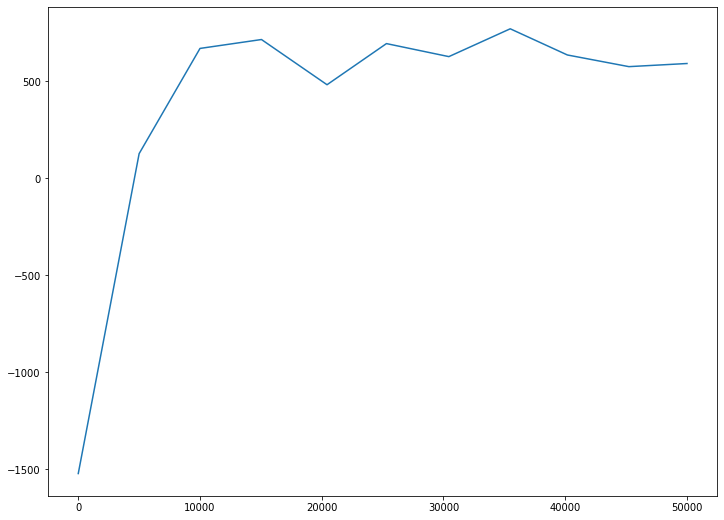

In [9]:
fig, ax = plt.subplots(1,1, figsize = (12,9))
sns.lineplot(evaluation_timesteps, evaluations, ax = ax)
plt.savefig('training_eval.png', bbox_inches = 'tight')

# Inference

In [10]:
monitor_dir = mkdir('.', 'monitor')
monitor_car_pov_dir = mkdir('.', 'monitor_car_pov')

# Env setup
inference_env_map = CityMap(citymap, roadmask, car_image_resized)
inference_env_map = wrappers.Monitor(inference_env_map, monitor_dir, force = True, video_callable=lambda episode_id: True)
inference_env_map.reset()

inference_env_car = CityMap(citymap, roadmask, car_image_resized, render_pov = 'car')
inference_env_car = wrappers.Monitor(inference_env_car, monitor_car_pov_dir, force = True, video_callable=lambda episode_id: True)
inference_env_car.reset();

/usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
/usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning: WARN: Trying to monitor an environment which has no 'spec' set. This usually means you did not create it via 'gym.make', and is recommended only for advanced users.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
/usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
/usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning: WARN: Trying to monitor an environment which has no 'spec' set. This usually means you did not create it via 'gym.make', and is recommended only for advanced users.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


What the car sees in the inference_env_car environment at the starting point

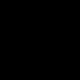

In [11]:
Image.fromarray( inference_env_car.unwrapped._extract_current_frame().squeeze(0).squeeze(0)*255 ).convert('L').resize((80,80))

In [0]:
# Loading the model
inference_policy = TD3(
    action_dim, 
    max_action, 
    batch_size = batch_size, 
    discount = discount, 
    polyak = polyak, 
    policy_noise = policy_noise, 
    noise_clip = noise_clip, 
    policy_freq = policy_freq, 
    actor_lr = actor_lr,
    critic_lr = critic_lr,
    device = device)
inference_policy.load(file_name, './pytorch_models/')

In [13]:
#Map POV
avg_reward_map = evaluate_policy(inference_policy, inference_env_map, eval_episodes=3)

# Wrapup recording
inference_env_map.close()
inference_env_map.stats_recorder.save_complete()
inference_env_map.stats_recorder.done = True

# #Car POV
avg_reward_car = evaluate_policy(inference_policy, inference_env_car, eval_episodes=3)

# Wrapup recording
inference_env_car.close()
inference_env_car.stats_recorder.save_complete()
inference_env_car.stats_recorder.done = True

---------------------------------------
Episode lengths:  [611, 605, 804]
Rewards per episode:  [675.2000000000011, 681.799999999998, 745.4999999999989]
Average Reward over the Evaluation Step: 700.833333
Average action: -0.012542
Std deviation action: 0.898388
---------------------------------------
---------------------------------------
Episode lengths:  [476, 554, 471]
Rewards per episode:  [498.2000000000011, 586.1000000000016, 542.0000000000011]
Average Reward over the Evaluation Step: 542.100000
Average action: -0.022165
Std deviation action: 0.892107
---------------------------------------
